In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches

In [ ]:
# Sharpening input
d_w = 250
l_p = 139
beta = math.radians(15)

In [4]:
# Machine settings
d_s = 12
d_j = 12
o_s = 50
h_c = 29

In [34]:
# for plotting
T8_width = 230  # actually 250, but this looks better
T8_height = 230
T8_height_to_curve = 175
T8_width_between_curves = 160

In [40]:
sj = (d_s + d_j)/2
tj = l_p - d_s/2
ts = math.sqrt(sj**2+tj**2)
alpha = math.atan(sj/tj)

print(f'sj: {sj}')
print(f'tj: {tj}')
print(f'ts: {ts}')
print(f'alpha: {alpha}')
print(f'alpha in degrees: {np.degrees(alpha)}')

sj: 12.0
tj: 133.0
ts: 133.5402561027947
alpha: 0.08998192120292317
alpha in degrees: 5.155584317406233


In [7]:
my = beta + math.pi/2 - alpha

print(f'my: {my}')
print(f'my in degrees: {np.degrees(my)}')

my: 1.7426137933911228
my in degrees: 99.84441568259376


In [8]:
r = d_w/2
os = math.sqrt(ts**2 + r**2 - 2*ts*r*math.cos(my))
h_r = os - r + d_s/2

print(f'r: {r}')
print(f'os: {os}')
print(f'h_r: {h_r}')

r: 125.0
os: 197.9039053955015
h_r: 78.90390539550151


In [9]:
sx = math.sqrt(os**2 - o_s**2)
h_n = sx - h_c + d_s/2
h_n

168.4835652759568

In [10]:
alpha_2 = math.acos((r*r - ts*ts + os*os)/(2*r*os))
alpha_3 = math.acos(o_s/os)
alpha_4 = math.pi - alpha_3 - alpha_2
alpha_5 = math.pi/2 - alpha_4
tx = r * math.cos(alpha_5)
xo = r * math.sin(alpha_5)
for i in [2,3,4,5]:
    a = 'alpha_'+ str(i)
    print(f'alpha_{i}: {math.degrees(eval(a))}')

alpha_2: 41.669870019063865
alpha_3: 75.3657450615755
alpha_4: 62.96438491936065
alpha_5: 27.03561508063935


In [41]:
axel_center = (0, 0)
support_center = (o_s, h_c + h_n - d_s/2)
tipp = (-xo, tx)

(-150.0, 217.40774353975465)

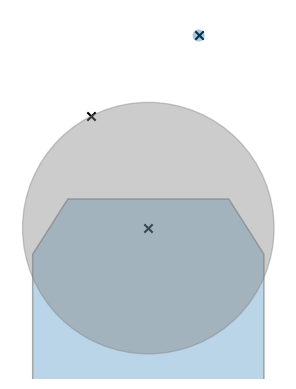

In [39]:
points = [axel_center, support_center, tipp]

fig, ax = plt.subplots()

plt.scatter(*zip(*points), marker="x", c='black')
ax.set_aspect('equal')

T8_base = h_c - T8_height
T8_top = h_c

Path = mpath.Path
path_data = [
    (Path.MOVETO, (-T8_width/2, T8_base)),
    (Path.LINETO, (T8_width/2, T8_base)),
    (Path.LINETO, (T8_width/2, T8_base + T8_height_to_curve)),
    (Path.LINETO, (T8_width_between_curves/2, T8_top)),
    (Path.LINETO, (-T8_width_between_curves/2, T8_top)),
    (Path.LINETO, (-T8_width/2,T8_base + T8_height_to_curve)),
    (Path.CLOSEPOLY, (-T8_width/2, T8_base)),
    ]
codes, verts = zip(*path_data)
T8_path = mpath.Path(verts, codes)
T8 = mpatches.PathPatch(T8_path, alpha=0.3)
ax.add_patch(T8)

support = mpatches.Circle(support_center, radius=d_s/2, alpha=0.4)
ax.add_patch(support)

stone = mpatches.Circle(axel_center, radius=d_w/2, alpha=0.4, color='grey')
ax.add_patch(stone)

ax.axis('off')
ax.set_ylim(bottom=-150)
